<a href="https://colab.research.google.com/github/cisprague/bts-2021/blob/main/notebooks/bts-2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# System identification of AUVs

Christopher Iliffe Sprague \\
sprague@kth.se

Sriharsha Bhat \\
svbhat@kth.se

# Outline

- Background
- What's the benifit?
- Data generation
- Model identification
- Simulation
- Discussion and future work

# Resources

In [240]:
import jax.numpy as np, matplotlib.pyplot as plt
from jax import jit
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

# Analytical model

In [241]:
def skew(l):
  return np.array([
    [0, -l[2], l[1]],
    [l[2], 0, -l[0]],
    [-l[1], l[0], 0]
  ])

In [242]:
@jit
def f(x, u, params):

  # state and control
  rpm1, rpm2, de, dr, lcg, vbs = u
  x, y, z, phi, theta, psi, u, v, w, p, q, r = x

  # position and velocity
  eta = np.array([x, y, z, phi, theta, psi])
  nu = np.array([u, v, w, p, q, r])

  # centre of gravity, buoyancy, and pressure positions
  rg = np.array([params['xg'], params['yg'], params['zg']])
  rb = np.array([params['xb'], params['yb'], params['zb']])
  rp = np.array([params['xcp'], params['ycp'], params['zcp']])

  # control actuators
  KT = np.array([params['Kt0'], params['Kt1']])
  QT = np.array([params['Qt0'], params['Qt1']])

  # mass and inertia matrix
  I = np.array([
    [params['Ixx'], 0, 0],
    [0, params['Iyy'], 0],
    [0, 0, params['Izz']]
  ])
  m = params['m']
  M = np.block([
    [m*np.eye(3,3), -m*skew(rg)],
    [m*skew(rg), I]
  ])
  assert M.shape == (6,6)

  # coriolis and centripetal matrix
  nu1 = np.array([u, v, w])
  nu2 = np.array([p, q, r])
  top_right = -m*skew(nu1) - m*skew(nu2)*skew(rg)
  bottom_left = -m*skew(nu1) + m*skew(rg)*skew(nu2)
  bottom_right = -skew(I.dot(nu2))
  CRB = np.block([
    [np.zeros((3,3)), top_right],
    [bottom_left, bottom_right]
  ])
  assert CRB.shape == (6, 6)

  # damping matrix
  forces = np.diag(np.array([
    params['Xuu']*np.abs(u), 
    params['Yvv']*np.abs(v), 
    params['Zww']*np.abs(w)
  ]))
  moments = np.diag(np.array([
    params['Kpp']*np.abs(p), 
    params['Mqq']*np.abs(q), 
    params['Nrr']*np.abs(r)
  ]))
  coupling = np.matmul(skew(rp), forces)
  D = np.block([
    [forces, np.zeros([3,3])],
    [-coupling, moments]
  ])
  assert D.shape == (6, 6)

  # rotational transform between body and NED in Euler        
  T_euler = np.array([
    [1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
    [0, np.cos(phi), -np.sin(phi)],
    [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)],
  ])
  R_euler = np.array([
    [
      np.cos(psi)*np.cos(theta),
      -np.sin(psi)*np.cos(phi)+np.cos(psi)*np.sin(theta)*np.sin(phi),
      np.sin(psi)*np.sin(phi)+np.cos(psi)*np.cos(phi)*np.sin(theta)
    ],
    [
      np.sin(psi)*np.cos(theta),
      np.cos(psi)*np.cos(phi)+np.sin(phi)*np.sin(theta)*np.sin(psi),
      -np.cos(psi)*np.sin(phi)+np.sin(theta)*np.sin(psi)*np.cos(phi),
    ],
    [
      -np.sin(theta),
      np.cos(theta)*np.sin(phi),
      np.cos(theta)*np.cos(phi),
    ],
  ])
  assert R_euler.shape == (3,3)

  J_eta = np.block([
    [R_euler, np.zeros((3,3))],
    [np.zeros((3,3)), T_euler]
  ])
  assert J_eta.shape == (6,6)

  # buoyancy in quaternions
  fg = np.array([0, 0, params['W']])
  fb = np.array([0, 0, -params['B']])
  row1 = np.linalg.inv(R_euler).dot(fg + fb)
  row2 = skew(rg).dot(np.linalg.inv(R_euler)).dot(fg) + skew(rb).dot(np.linalg.inv(R_euler)).dot(fb)
  geta = np.block([row1, row2])
  assert geta.shape == (6,)

  # [Insert title]
  FT = KT.dot(np.array([rpm1, rpm2]))
  MT = QT.dot(np.array([rpm1, rpm2]))
  tauc = np.array([
    FT*np.cos(de)*np.cos(dr),
    -FT*np.sin(dr),
    FT*np.sin(de)*np.cos(dr),
    MT*np.cos(de)*np.cos(dr),
    -MT*np.sin(dr),
    MT*np.sin(de)*np.cos(dr)
  ])
  assert tauc.shape == (6,)

  # velocity and acceleration
  etadot = np.block([J_eta.dot(nu)])
  nudot = np.linalg.inv(M).dot(tauc - ((CRB + D).dot(nu - geta)))

  # state-space
  sdot = np.block([etadot, nudot])
  # print(sdot)
  return sdot

In [243]:
params = dict(
  Nrr=150., Izz=10., Kt1=0.1, zb=0., Mqq=100., 
  ycp=0., xb=0., zcp=0., Yvv=100., yg=0., Ixx=10., 
  Kt0=0.1, Xuu=1., xg=0., Zww=100., W=15.4*9.81, 
  m=15.4, B=15.4*9.81, zg=0., Kpp=100., Qt1=-0.001, 
  Qt0=0.001, Iyy=10., yb=0., xcp=0.1
)

In [244]:
def simulate(x, T, pi, params):
  sol = solve_ivp(
      lambda t, x: f(x, pi(x), params),
      (0, T),
      x,
      method='RK45',
      atol=1e-5,
      rtol=1e-5
  )
  return sol.y.T, sol.t

In [249]:
x = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
T = 50
pi = lambda x: np.array([1000.0, 1000.0, 0.1, 0.1, 0, 0])
trajectory, times = simulate(x, T, pi, params)

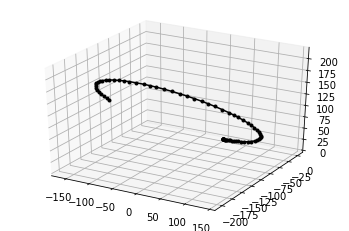

In [250]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2], 'k.-')
plt.show()